### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [1]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math 
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


In [2]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [3]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")

#restrict the wharton research data to the columns of interest
#Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
cols = ['Vol']
Y = wrds_tics.loc[:,cols] # Y matrix in formulation

def vol_data_treatment(Y):
    Y.Vol = -1*Y.Vol/Y.Vol.std(axis=0) #for Vol Limit
    return Y

Y = vol_data_treatment(Y)

ret_constr = 0.01 #no return constraint
soft_margin = 5000 #large preference for separation feasibility

name = "no_tlim"
ratio = 0.7 #% of assets
card_desc = "Card07"

turnover_descs = ["0_75", "1", "1_25"]
turnovers = [0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
epsilons = [1e-2, 1e-3, 1e-4, 1e-5] # is no SVM consideration
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4", 1e-5:"eps negative 5"}
card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}

dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [4]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 60s
    if time.time() - model._time > 120:
        model.terminate()

### Simple Min Variance Portfolio 

In [5]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin,Y , AssetLim,\
             svm_choice = (False, False), print_var_frntr= True,
             cardinality = False)#define an instance of the class

MVO.set_model() #set up the model
MVO.model.Params.timelimit = 15
MVO.model.Params.MIPGAP = 0.05
MVO.optimize() #find optimal solution

Set parameter TimeLimit to value 15
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0x000b6c30
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.02s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MB of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          Dual         Primal    

0.10526728630065918

### Mean Variance and SVM Joint Formulation

In [6]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin,Y , AssetLim,
                 svm_choice = (True, False), print_var_frntr = False,
                 indicator = False, non_neg = non_negativity_setting, epsilon = epsilon)#define an instance of the class )
SVM_MVO.set_model()
SVM_MVO.model.Params.timelimit = 15
SVM_MVO.optimize()

Set parameter TimeLimit to value 15
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 860 columns and 3432 nonzeros
Model fingerprint: 0x3afbc337
Model has 41042 quadratic objective terms
Variable types: 574 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Presolve removed 1 rows and 286 columns
Presolve time: 0.02s
Presolved: 861 rows, 574 columns, 3146 nonzeros
Presolved model has 41042 quadratic objective terms
Variable types: 288 continuous, 286 integer (286 binary)

Root relaxation: objective 6.862430e-04, 689 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

8.881148099899292

### Mean Variance and SVM Joint Formulation with Slacks

In [7]:
SVM_MVO.b.x/SVM_MVO.w.x

array([0.69207812])

In [8]:
SVM_MVO.w.x

array([0.08200898])

In [9]:
#SVM with slack
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin,Y , AssetLim,
                      svm_choice = (True, True), print_var_frntr = False, non_neg = non_negativity_setting, epsilon = epsilon)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.model.Params.timelimit = 15

SVM_MVO_Slck.optimize(cbb=cb)

Set parameter TimeLimit to value 15
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 1146 columns and 4004 nonzeros
Model fingerprint: 0xc95a69c2
Model has 41042 quadratic objective terms
Variable types: 860 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 1.000000e+13
Presolve removed 1 rows and 286 columns
Presolve time: 0.00s
Presolved: 861 rows, 860 columns, 3718 nonzeros
Presolved model has 41042 quadratic objective terms
Variable types: 574 continuous, 286 integer (286 binary)

Root relaxation: objective 6.862430e-04, 689 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

10.290796041488647

In [10]:
SVM_MVO_Slck.b.x

array([0.05811161])

In [11]:
SVM_MVO_Slck.w.x

array([0.08376883])

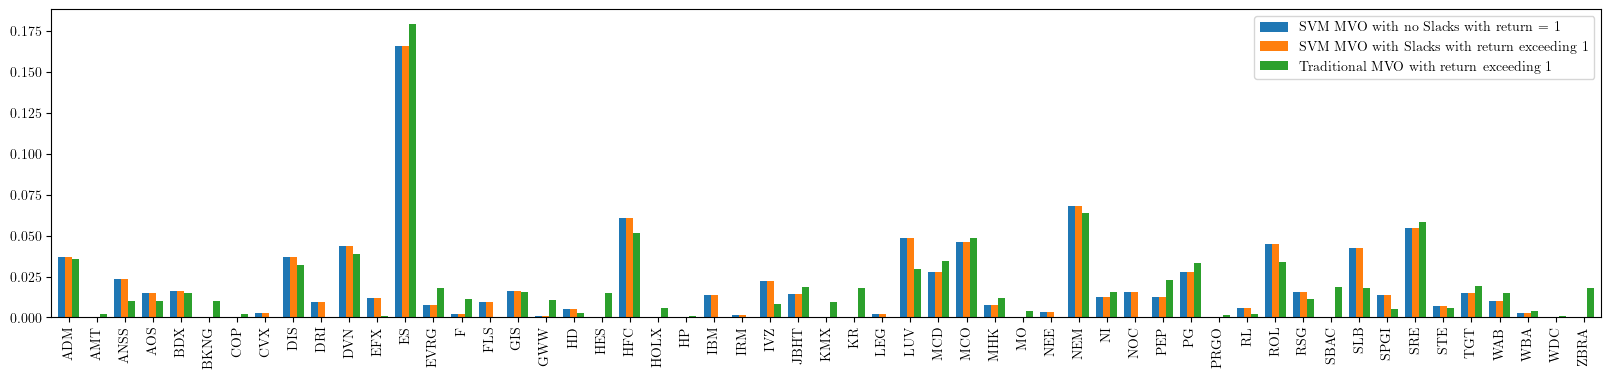

In [12]:
#portfolio comparison
#out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), MVO.get_results()], axis = 0)
out = pd.concat([SVM_MVO.get_results(), SVM_MVO_Slck.get_results(), MVO.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

In [5]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

In [ ]:
for ratio, epsilon in product(ratios, epsilons):
    AssetLim = math.floor(N*ratio)

    SVM_MVO_Slck.AssetLim = AssetLim
    SVM_MVO_Slck.epsilon = epsilon

    card_desc = card_desc_list[ratio]
    print("processing asset limit ", AssetLim)

    isExist = os.path.exists("cache/Local Experiments/"+epsilons_desc[epsilon])
    if not isExist:
        os.makedirs("cache/Local Experiments/"+epsilons_desc[epsilon])
        print("The new directory is created!")
    for i in range(len(turnovers)):
        turnover = turnovers[i]
        turnover_desc = turnover_descs[i]
        svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck,
                                     T, N, cols, turnover, cbb_fn=cb, lr=None, data_treatment=vol_data_treatment)
        col_string = "".join(map(str, cols))
        out_pth = "cache/Local Experiments/"+epsilons_desc[epsilon] + "/" + card_desc + "_" +col_string + "_" +turnover_desc + name + ".pkl"
        with open(out_pth, 'wb') as fp:
          pkl.dump(svm_results, fp)
#end here for now - 1:32 AM 2022 - 10 22

processing asset limit  28
_________________________
Iteration  0
Percent Complete  0.0
_________________________
Iteration  12
Percent Complete  0.04938271604938271
_________________________
Iteration  24
Percent Complete  0.09876543209876543
_________________________
Iteration  36
Percent Complete  0.14814814814814814
_________________________
Iteration  48
Percent Complete  0.19753086419753085
_________________________
Iteration  60
Percent Complete  0.24691358024691357
_________________________
Iteration  72
Percent Complete  0.2962962962962963
_________________________
Iteration  84
Percent Complete  0.345679012345679
_________________________
Iteration  96
Percent Complete  0.3950617283950617
_________________________
Iteration  108
Percent Complete  0.4444444444444444
_________________________
Iteration  120
Percent Complete  0.49382716049382713
_________________________
Iteration  132
Percent Complete  0.5432098765432098
_________________________
Iteration  144
Percent Complete

### Part 2 Cardinalty Constrained MVO

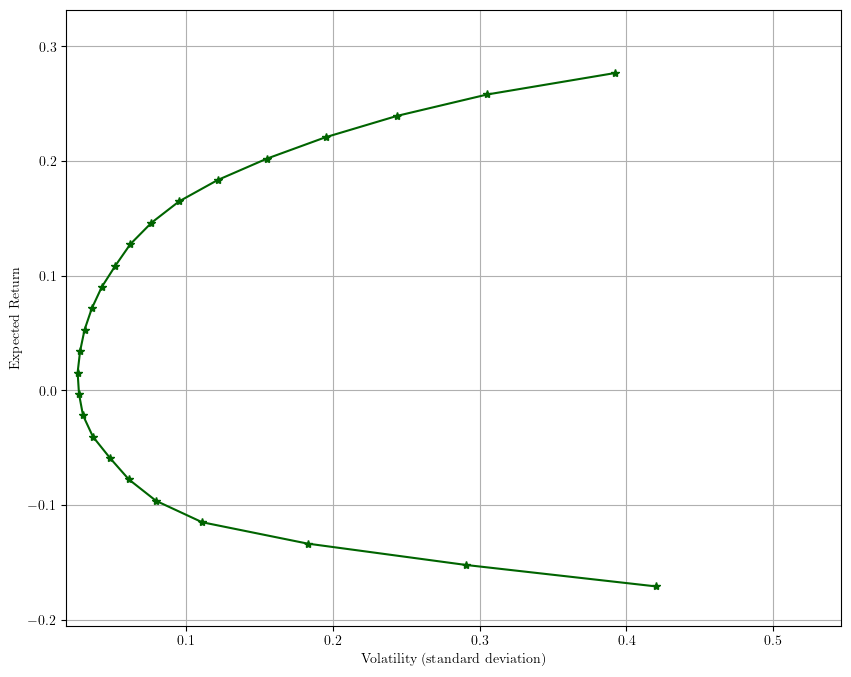

In [8]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.model.params.outputflag = 0
MVO2.model.params.timelimit = 15
MVO2.model.params.MIPGap = 0.05
MVO2.optimize() #find optimal solution
mv_ef = MVO2.get_frontier()

def do_nothing(Y):
    return Y

In [10]:
isExist = os.path.exists("cache/Local Experiments/Cardinality Portfolios")
if not isExist:
    os.makedirs("cache/Local Experiments/Cardinality Portfolios")
    print("The new directory is created!")
for ratio in ratios:
    AssetLim = math.floor(N*ratio)

    MVO2.AssetLim = AssetLim

    card_desc = card_desc_list[ratio]
    print("processing asset limit ", AssetLim)

    for i in range(len(turnovers)):
        turnover = turnovers[i]
        turnover_desc = turnover_descs[i]
        card_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO2,
                                     T, N, cols, turnover, cbb_fn=cb, lr=None, data_treatment=do_nothing)
        out_pth = "cache/Local Experiments/Cardinality Portfolios" + "/" + card_desc + "_" +turnover_desc + name + ".pkl"
        with open(out_pth, 'wb') as fp:
          pkl.dump(card_results, fp)
#end here for now - 1:32 AM 2022 - 10 22

processing asset limit  200
_________________________
Iteration  0
Percent Complete  0.0
_________________________
Iteration  12
Percent Complete  0.04938271604938271
_________________________
Iteration  24
Percent Complete  0.09876543209876543
_________________________
Iteration  36
Percent Complete  0.14814814814814814
_________________________
Iteration  48
Percent Complete  0.19753086419753085
_________________________
Iteration  60
Percent Complete  0.24691358024691357
_________________________
Iteration  72
Percent Complete  0.2962962962962963
_________________________
Iteration  84
Percent Complete  0.345679012345679
_________________________
Iteration  96
Percent Complete  0.3950617283950617
_________________________
Iteration  108
Percent Complete  0.4444444444444444
_________________________
Iteration  120
Percent Complete  0.49382716049382713
_________________________
Iteration  132
Percent Complete  0.5432098765432098
_________________________
Iteration  144
Percent Complet